In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './TCIA_splitted_intra'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
test_transforms = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './TCIA_splitted_intra'
test_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          test_transforms[x])
                  for x in ['test']}
testloaders = {x: torch.utils.data.DataLoader(test_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['test']}
testset_sizes = {x: len(test_datasets[x]) for x in ['test']}
class_names = test_datasets['test'].classes

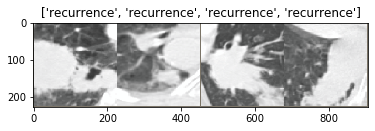

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss=[]
    val_loss=[]
    test_loss=[]
    train_acc=[]
    val_acc=[]
    test_acc=[]
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val','test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase=='train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            elif phase=='val':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
            else:
                test_loss.append(epoch_loss)
                test_acc.append(epoch_acc)
            #print(phase,train_loss,val_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    plt.title('model loss')
    plt.plot(train_loss,'r',val_loss,'g',test_loss,'b')
    plt.legend(['train','val','test'])
    plt.show()
    plt.title('model accuracy')
    plt.plot(train_acc,'r',val_acc,'g',test_acc,'b')
    plt.legend(['train','val','test'])
    plt.show()
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,best_acc

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
def getConfusionMatrix(model, show_image=False):
    model.eval()
    confusion_matrix=np.zeros((2,2),dtype=int)
    num_images=testset_sizes['test']
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                if preds[j]==1 and labels[j]==1:
                    term='TP'
                    confusion_matrix[0][0]+=1
                elif preds[j]==1 and labels[j]==0:
                    term='FP'
                    confusion_matrix[1][0]+=1
                elif preds[j]==0 and labels[j]==1:
                    term='FN'
                    confusion_matrix[0][1]+=1
                elif preds[j]==0 and labels[j]==0:
                    term='TN'
                    confusion_matrix[1][1]+=1
                    
                if show_image:
                    print('predicted: {}'.format(class_names[preds[j]]))
                    print(term)
                    imshow(inputs.cpu().data[j])
                    print()
        print('Confusion Matrix: ')
        print(confusion_matrix)
        print()
        print('Sensitivity: ', 100*confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1]))
        print('Specificity: ', 100*confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0]))
        print('PPV: ', 100*confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[1][0]))
        print('NPV: ', 100*confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[0][1]))
        
        #return confusion_matrix

In [8]:
def test_acc(model):
    correct = 0
    total = 0
    correct_list=[]
    model.eval()
    
    with torch.no_grad():
        for data in testloaders['test']:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            for i in range(0,len(labels.tolist())):
                if labels.tolist()[i]==predicted.tolist()[i]:
                    correct_list.append(1)
                else:
                    correct_list.append(0)
            '''
            print('label: ',labels.tolist())
            print('predicted: ',predicted.tolist())
            print('correct_list: ',correct_list)
            print()    
            '''      
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Testset Accuracy(mean): %f %%' % (100 * correct / total))
        print('Testset Accuracy(standard deviation): %f %%' % (np.std(correct_list)*100))
            
    return correct / total, np.std(correct_list)

In [9]:
####hyperparameter###

learning_rate=0.003

In [10]:
model_temp=models.alexnet(pretrained=True)
conv_layer=[]
for cnt in range(len(model_temp.features)):
    for param in model_temp.features[cnt].parameters():
        conv_layer.append(cnt)
conv_layer=list(set(conv_layer))

In [11]:
conv_layer

[0, 3, 6, 8, 10]

In [12]:
#freezen 1-2 conv layer
model_conv2 = torchvision.models.alexnet(pretrained=True)
for cnt in range(conv_layer[1]+1):
    for param in model_conv2.features[cnt].parameters():
        param.requires_grad = False
        print(cnt,model_conv2.features[cnt],': freeze')

num_ftrs = model_conv2.classifier[6].in_features
model_conv2.classifier[6] = nn.Linear(num_ftrs, 2)

model_conv2= model_conv2.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(filter(lambda p: p.requires_grad, model_conv2.parameters()), lr=learning_rate, momentum=0.7)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

0 Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)) : freeze
0 Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)) : freeze
3 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) : freeze
3 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) : freeze


Epoch 0/24
----------
train Loss: 0.8530 Acc: 0.6000
val Loss: 0.7220 Acc: 0.6667
test Loss: 0.7246 Acc: 0.7000

Epoch 1/24
----------
train Loss: 0.6748 Acc: 0.6923
val Loss: 0.6686 Acc: 0.6667
test Loss: 0.6103 Acc: 0.7000

Epoch 2/24
----------
train Loss: 0.6253 Acc: 0.6923
val Loss: 0.6649 Acc: 0.6667
test Loss: 0.6258 Acc: 0.7000

Epoch 3/24
----------
train Loss: 0.6109 Acc: 0.6923
val Loss: 0.6086 Acc: 0.6667
test Loss: 0.6700 Acc: 0.7000

Epoch 4/24
----------
train Loss: 0.6179 Acc: 0.6769
val Loss: 0.7313 Acc: 0.6667
test Loss: 0.7103 Acc: 0.7000

Epoch 5/24
----------
train Loss: 0.5944 Acc: 0.6308
val Loss: 0.7293 Acc: 0.6667
test Loss: 0.7895 Acc: 0.7000

Epoch 6/24
----------
train Loss: 0.5728 Acc: 0.6923
val Loss: 0.6347 Acc: 0.7333
test Loss: 0.7084 Acc: 0.6500

Epoch 7/24
----------
train Loss: 0.5563 Acc: 0.6769
val Loss: 0.6470 Acc: 0.6667
test Loss: 0.7167 Acc: 0.6500

Epoch 8/24
----------
train Loss: 0.5507 Acc: 0.7538
val Loss: 0.6523 Acc: 0.6667
test Loss: 0.7

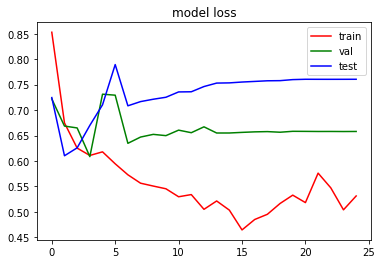

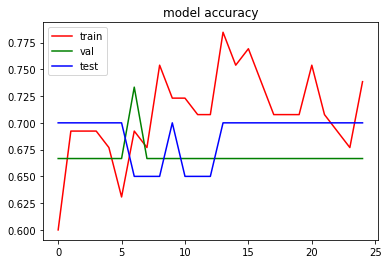

In [13]:
model_conv2,best_acc2= train_model(model_conv2, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [14]:
acc_mean2,acc_std2=test_acc(model_conv2)

Testset Accuracy(mean): 65.000000 %
Testset Accuracy(standard deviation): 47.696960 %


predicted: recurrence
TP


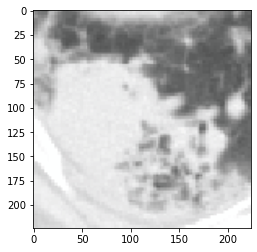


predicted: recurrence
TP


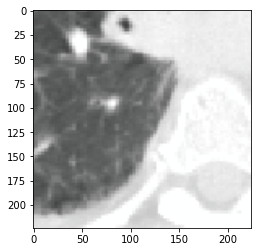


predicted: recurrence
TP


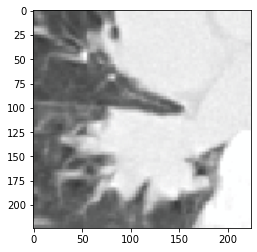


predicted: recurrence
TP


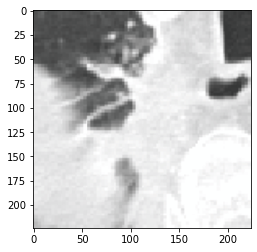


predicted: recurrence
TP


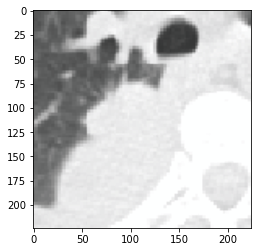


predicted: recurrence
TP


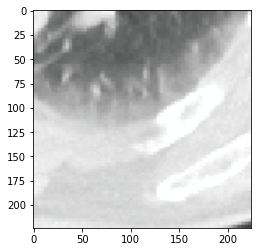


predicted: recurrence
FP


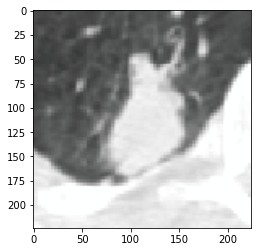


predicted: non-recurrence
FN


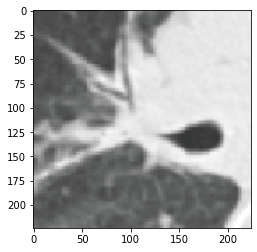


predicted: recurrence
FP


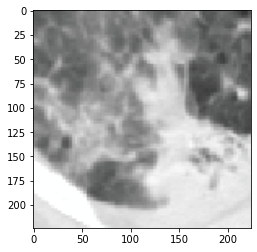


predicted: recurrence
FP


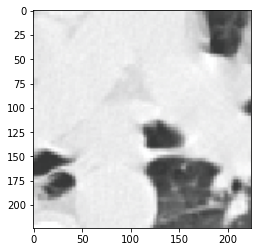


predicted: recurrence
TP


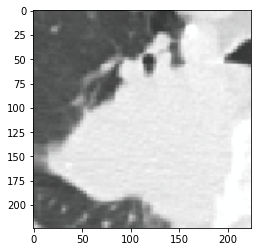


predicted: recurrence
FP


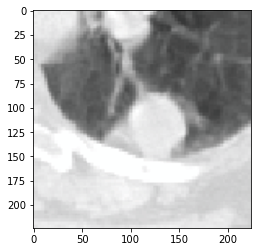


predicted: recurrence
TP


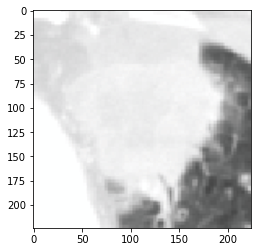


predicted: recurrence
TP


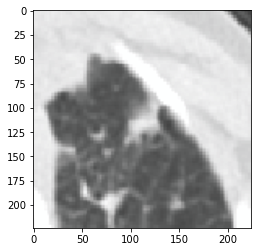


predicted: recurrence
TP


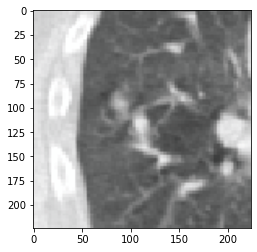


predicted: recurrence
FP


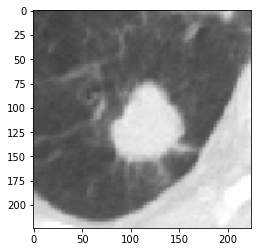


predicted: recurrence
TP


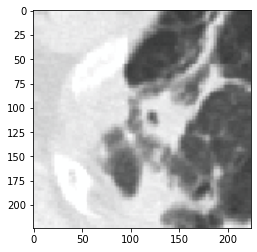


predicted: recurrence
TP


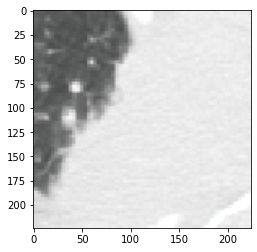


predicted: recurrence
FP


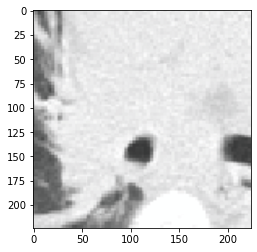


predicted: recurrence
TP


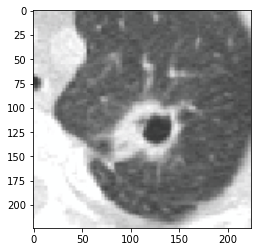


Confusion Matrix: 
[[13  1]
 [ 6  0]]

Sensitivity:  92.85714285714286
Specificity:  0.0
PPV:  68.42105263157895
NPV:  0.0


In [28]:
getConfusionMatrix(model_conv2,show_image=True)

In [20]:
#freeze 1-4conv layer
model_conv4 = torchvision.models.alexnet(pretrained=True)
for cnt in range(conv_layer[3]+1):
    for param in model_conv4.features[cnt].parameters():
        param.requires_grad = False
        print(cnt,model_conv4.features[cnt],': freeze')

num_ftrs = model_conv4.classifier[6].in_features
model_conv4.classifier[6] = nn.Linear(num_ftrs, 2)

model_conv4= model_conv4.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(filter(lambda p: p.requires_grad, model_conv4.parameters()), lr=learning_rate, momentum=0.7)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

0 Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)) : freeze
0 Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)) : freeze
3 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) : freeze
3 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) : freeze
6 Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) : freeze
6 Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) : freeze
8 Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) : freeze
8 Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) : freeze


Epoch 0/24
----------
train Loss: 1.2981 Acc: 0.4615
val Loss: 0.8533 Acc: 0.5333
test Loss: 1.4885 Acc: 0.4500

Epoch 1/24
----------
train Loss: 0.7617 Acc: 0.6615
val Loss: 0.7175 Acc: 0.6000
test Loss: 0.6873 Acc: 0.5500

Epoch 2/24
----------
train Loss: 0.6452 Acc: 0.6000
val Loss: 0.8152 Acc: 0.5333
test Loss: 0.6690 Acc: 0.6500

Epoch 3/24
----------
train Loss: 0.5919 Acc: 0.6923
val Loss: 0.7680 Acc: 0.4667
test Loss: 0.6975 Acc: 0.6500

Epoch 4/24
----------
train Loss: 0.5353 Acc: 0.7692
val Loss: 0.7469 Acc: 0.7333
test Loss: 0.8181 Acc: 0.6500

Epoch 5/24
----------
train Loss: 0.5335 Acc: 0.7385
val Loss: 0.8203 Acc: 0.5333
test Loss: 0.7909 Acc: 0.5500

Epoch 6/24
----------
train Loss: 0.4912 Acc: 0.7538
val Loss: 0.9588 Acc: 0.4667
test Loss: 0.9377 Acc: 0.4500

Epoch 7/24
----------
train Loss: 0.4418 Acc: 0.7846
val Loss: 0.9392 Acc: 0.5333
test Loss: 0.9138 Acc: 0.5000

Epoch 8/24
----------
train Loss: 0.4352 Acc: 0.8000
val Loss: 0.9091 Acc: 0.5333
test Loss: 0.9

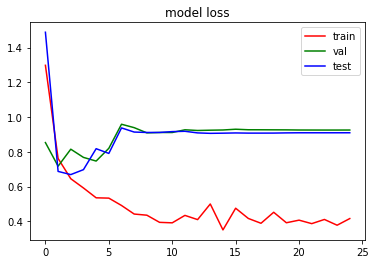

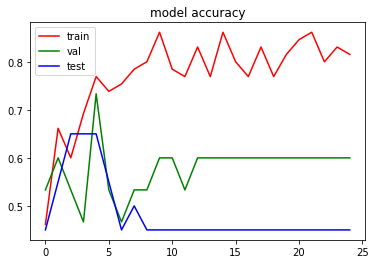

In [21]:
model_conv4,best_acc4= train_model(model_conv4, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [22]:
acc_mean4,acc_std4=test_acc(model_conv4)

Testset Accuracy(mean): 65.000000 %
Testset Accuracy(standard deviation): 47.696960 %


predicted: recurrence
TP


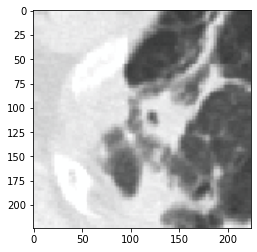


predicted: recurrence
TP


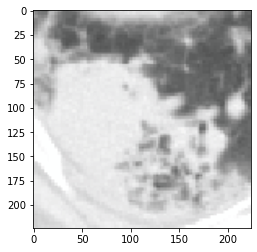


predicted: recurrence
TP


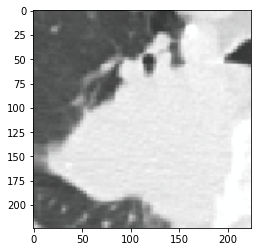


predicted: recurrence
TP


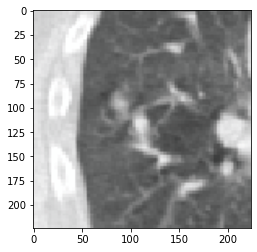


predicted: recurrence
FP


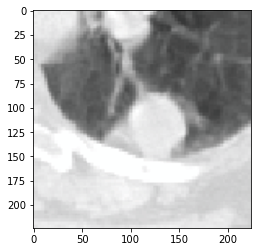


predicted: recurrence
TP


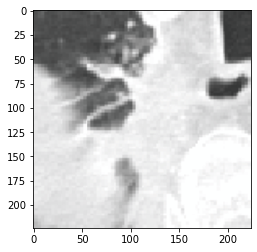


predicted: recurrence
FP


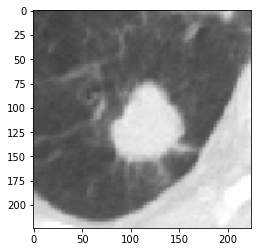


predicted: recurrence
FP


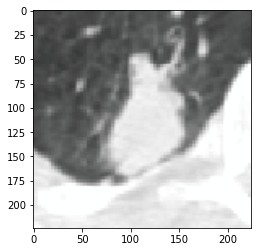


predicted: recurrence
TP


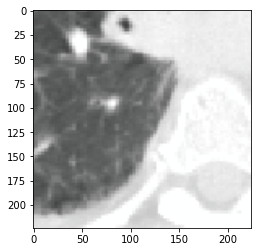


predicted: recurrence
FP


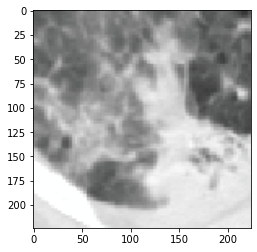


predicted: recurrence
FP


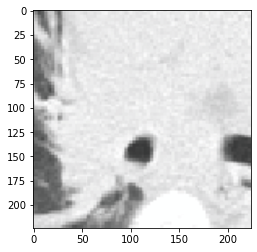


predicted: recurrence
TP


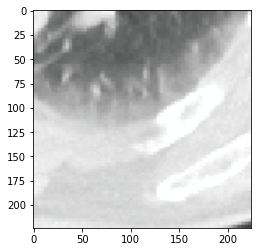


predicted: recurrence
TP


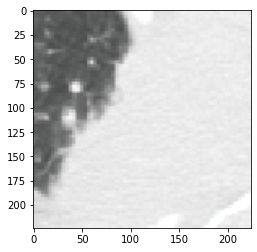


predicted: recurrence
TP


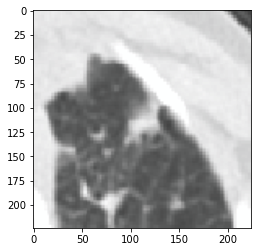


predicted: recurrence
TP


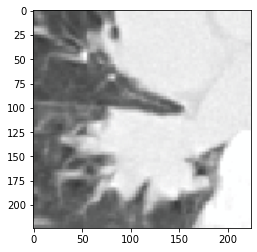


predicted: non-recurrence
FN


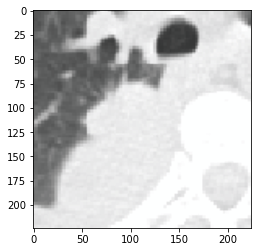


predicted: recurrence
TP


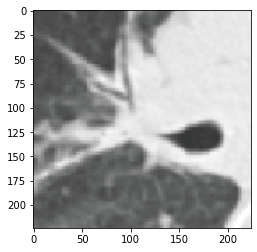


predicted: recurrence
TP


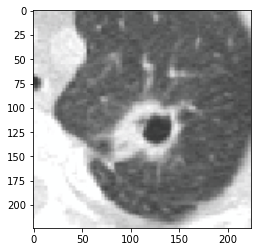


predicted: recurrence
FP


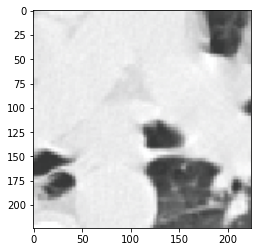


predicted: recurrence
TP


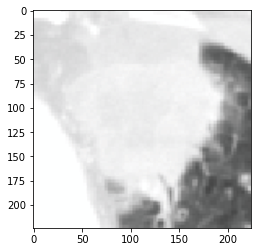


Confusion Matrix: 
[[13  1]
 [ 6  0]]

Sensitivity:  92.85714285714286
Specificity:  0.0
PPV:  68.42105263157895
NPV:  0.0


In [29]:
getConfusionMatrix(model_conv4,show_image=True)

In [24]:
#freeze 1-5conv layer
model_conv5 = torchvision.models.alexnet(pretrained=True)
for cnt in range(conv_layer[4]+1):
    for param in model_conv5.features[cnt].parameters():
        param.requires_grad = False
        print(cnt,model_conv5.features[cnt],': freeze')

num_ftrs = model_conv5.classifier[6].in_features
model_conv5.classifier[6] = nn.Linear(num_ftrs, 2)

model_conv5= model_conv5.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(filter(lambda p: p.requires_grad, model_conv5.parameters()), lr=learning_rate, momentum=0.7)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

0 Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)) : freeze
0 Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)) : freeze
3 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) : freeze
3 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) : freeze
6 Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) : freeze
6 Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) : freeze
8 Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) : freeze
8 Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) : freeze
10 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) : freeze
10 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) : freeze


Epoch 0/24
----------
train Loss: 1.4018 Acc: 0.5385
val Loss: 1.1115 Acc: 0.6667
test Loss: 1.6077 Acc: 0.5500

Epoch 1/24
----------
train Loss: 1.5616 Acc: 0.4769
val Loss: 0.6625 Acc: 0.6667
test Loss: 1.1624 Acc: 0.6000

Epoch 2/24
----------
train Loss: 0.6697 Acc: 0.7231
val Loss: 0.7572 Acc: 0.4667
test Loss: 1.0737 Acc: 0.6000

Epoch 3/24
----------
train Loss: 0.7139 Acc: 0.6462
val Loss: 1.1800 Acc: 0.4000
test Loss: 1.0721 Acc: 0.5500

Epoch 4/24
----------
train Loss: 0.5490 Acc: 0.7385
val Loss: 1.0685 Acc: 0.4667
test Loss: 1.0007 Acc: 0.6000

Epoch 5/24
----------
train Loss: 0.7389 Acc: 0.7077
val Loss: 1.0446 Acc: 0.5333
test Loss: 0.8537 Acc: 0.5500

Epoch 6/24
----------
train Loss: 0.4609 Acc: 0.7846
val Loss: 1.1994 Acc: 0.4667
test Loss: 1.0595 Acc: 0.6000

Epoch 7/24
----------
train Loss: 0.5166 Acc: 0.7538
val Loss: 1.1000 Acc: 0.3333
test Loss: 0.9422 Acc: 0.6500

Epoch 8/24
----------
train Loss: 0.4566 Acc: 0.7692
val Loss: 1.0666 Acc: 0.4000
test Loss: 0.9

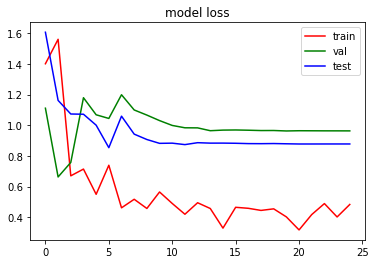

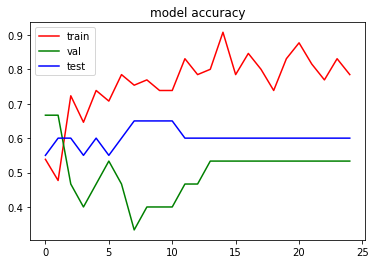

In [25]:
model_conv5 ,best_acc5= train_model(model_conv5, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [26]:
acc_mean5,acc_std5=test_acc(model_conv5)

Testset Accuracy(mean): 55.000000 %
Testset Accuracy(standard deviation): 49.749372 %


predicted: recurrence
TP


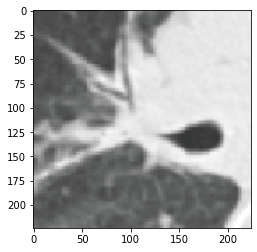


predicted: recurrence
FP


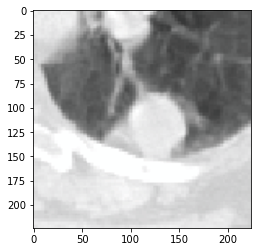


predicted: recurrence
TP


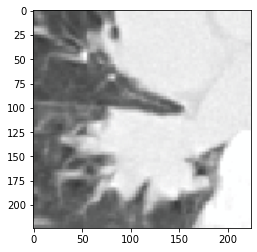


predicted: recurrence
TP


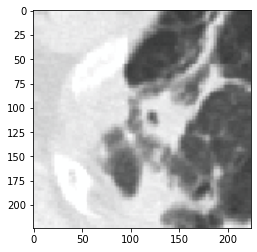


predicted: recurrence
TP


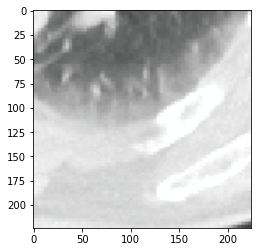


predicted: recurrence
TP


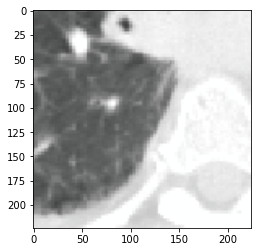


predicted: recurrence
TP


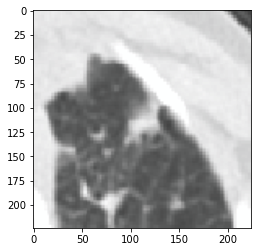


predicted: recurrence
TP


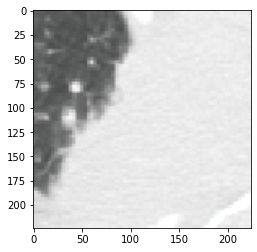


predicted: recurrence
FP


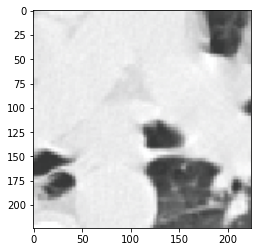


predicted: recurrence
TP


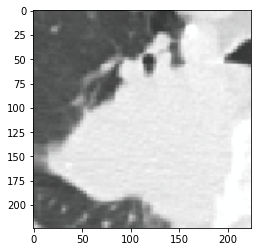


predicted: recurrence
TP


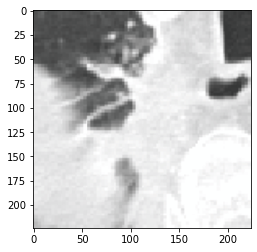


predicted: recurrence
FP


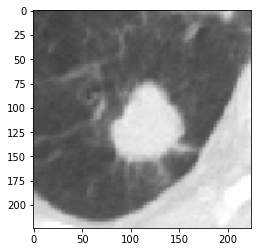


predicted: recurrence
FP


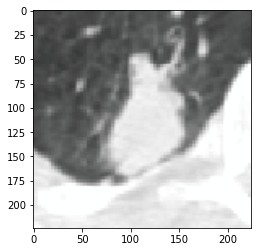


predicted: recurrence
TP


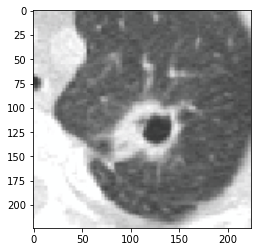


predicted: non-recurrence
FN


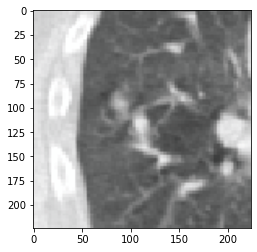


predicted: non-recurrence
FN


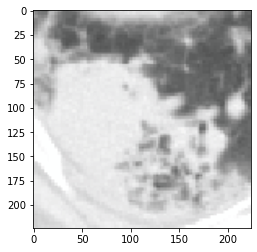


predicted: recurrence
FP


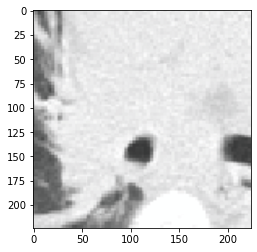


predicted: non-recurrence
FN


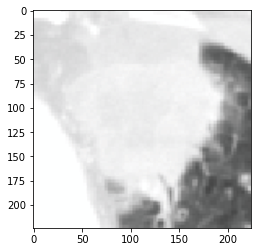


predicted: recurrence
TP


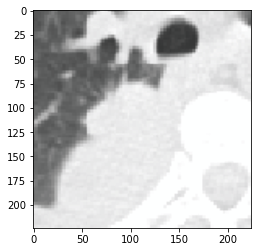


predicted: recurrence
FP


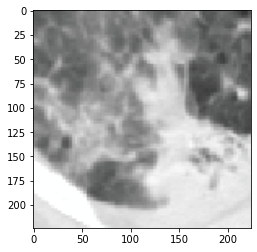


Confusion Matrix: 
[[11  3]
 [ 6  0]]

Sensitivity:  78.57142857142857
Specificity:  0.0
PPV:  64.70588235294117
NPV:  0.0


In [30]:
getConfusionMatrix(model_conv5,show_image=True)